In [111]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models, transforms
from PIL import Image

In [112]:
Dataset_path="Downloads/exam"
IMG_SIZE=(224,224)
BATCH_SIZE=32
SEED=42

In [113]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    Dataset_path,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)
full_val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    Dataset_path,
    validation_split=0.3,
    seed=SEED,
    subset="validation",
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

train_size=len(train_ds)
val_size=len(full_val_ds)//2
test_size=len(full_val_ds)-val_size

valid_ds=full_val_ds.take(val_size)
test_ds=full_val_ds.skip(val_size)

Found 1000 files belonging to 2 classes.
Using 700 files for training.
Found 1000 files belonging to 2 classes.
Using 300 files for validation.


In [114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [115]:
model=Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3), padding='same', name='conv1'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same', name='conv2'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu',padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu',padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 28, 28, 128)     

In [116]:
history=model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=1)

22/22 [==============================] - 39s 2s/step - loss: 2.7237 - accuracy: 0.4943 - val_loss: 0.7551 - val_accuracy: 0.4812


In [123]:
def preprocess(image):
    image=tf.image.resize(image, (224,224))
    image=tf.cast(image,tf.float32)/255.0
    return image
    
preprocessed_ds=train_ds.map(lambda img, label: (preprocess(img),label)).batch(1)


In [124]:
image,label=next(iter(preprocessed_ds))
for images,label in train_ds.take(1):
    single_image=images[0].numpy()
    break
single_image.shape
input_tensor = np.expand_dims(single_image, axis=0)
input_tensor.shape

(1, 224, 224, 3)

In [125]:
target_layer_name="conv2d_7"
target_layer=model.get_layer(target_layer_name)


In [126]:
grad_model=tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[target_layer.output, model.output]
)

In [127]:
with tf.GradientTape() as tape:
    conv_output, predictions= grad_model(input_tensor)
    loss=predictions[:,0]
grads=tape.gradient(loss, conv_output)

In [128]:
import cv2
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Average gradients
conv_output = conv_output[0]  # Use the first element if conv_output has a batch dimension
heatmap = conv_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Apply ReLU
heatmap = tf.maximum(heatmap, 0)

# Normalize the heatmap
max_val = tf.reduce_max(heatmap)
if max_val != 0:
    heatmap /= max_val

# Convert to numpy
heatmap = heatmap.numpy()

# Convert heatmap to uint8 for visualization
heatmap = np.uint8(255 * heatmap)  # Scale to [0, 255] for color mapping
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color map

# Prepare the original image for superimposition


# Display the results



In [129]:
img = input_tensor[0]  # Assuming input_tensor is a batch of images
img_min = img.min()
img_max = img.max()

# Normalize the image to [0, 1]
if img_max - img_min > 0:
    img = (img - img_min) / (img_max - img_min)

# Convert the image to BGR for OpenCV compatibility
original = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
original = np.uint8(255 * original)
# Ensure both images have the same size
heatmap = cv2.resize(heatmap, (original.shape[1], original.shape[0]))

# Superimpose heatmap onto original image
superimposed_img = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

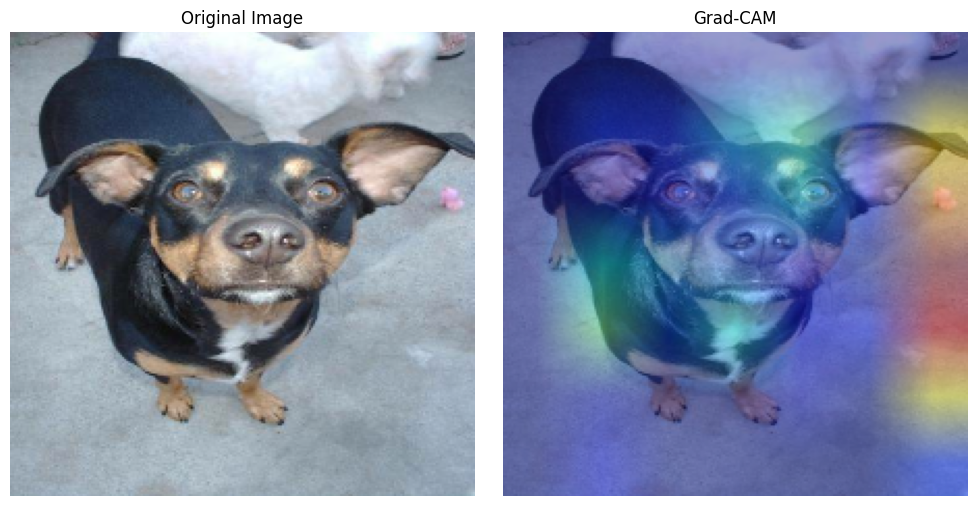

In [130]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()